[Tworzenie i optymalizowanie hurtowni danych przy użyciu BigQuery: Challenge Lab](https://www.cloudskillsboost.google/focuses/14341?locale=pl&parent=catalog)

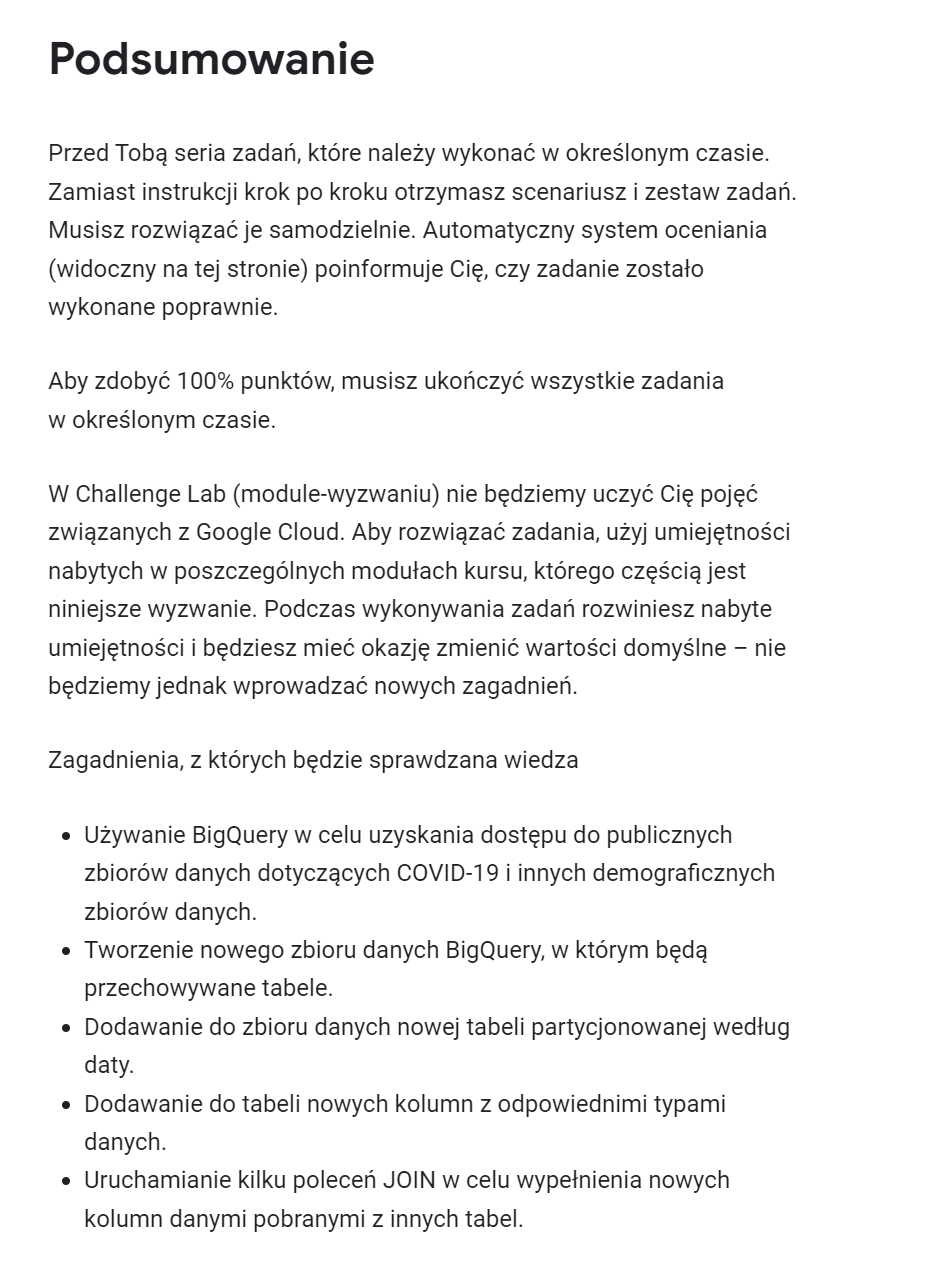

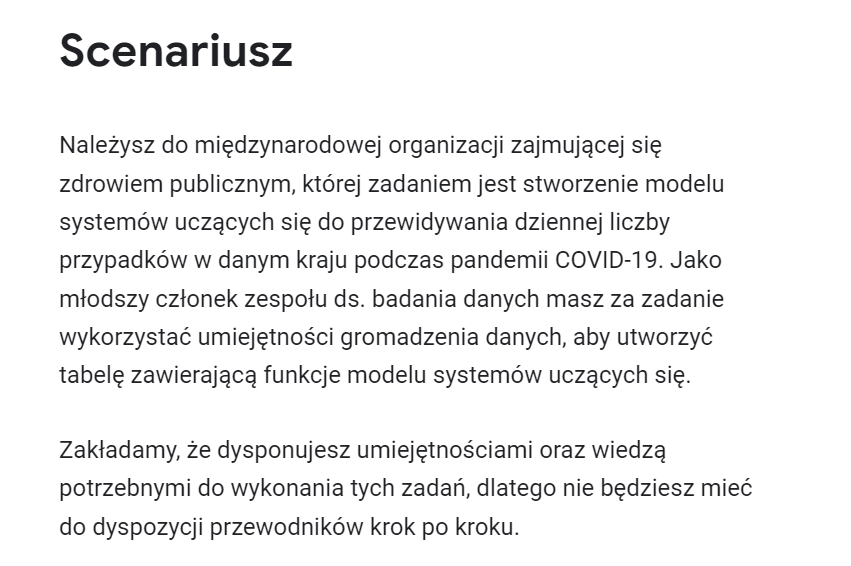

##Zadanie 1. Utwórz tabelę partycjonowaną według daty

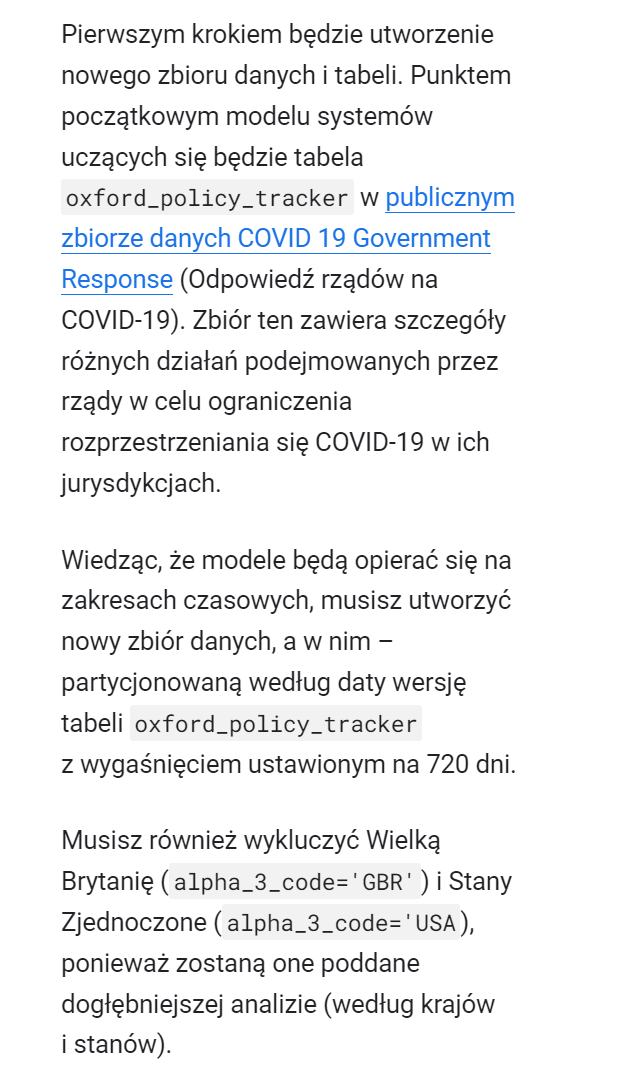

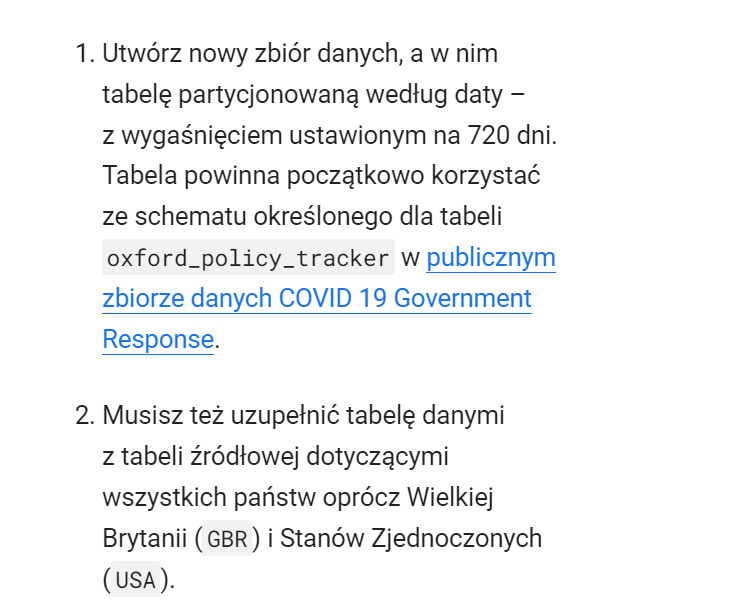

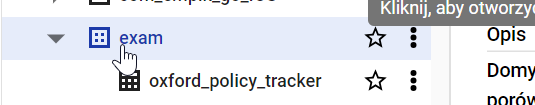

In [ ]:
%%bigquery

 CREATE OR REPLACE TABLE covid_359.oxford_policy_tracker_834
 PARTITION BY date
 OPTIONS (
   partition_expiration_days=720
 ) AS
SELECT *

FROM `bigquery-public-data.covid19_govt_response.oxford_policy_tracker`

where alpha_3_code not in ('GBR', 'USA')

In [ ]:
%%bigquery

 CREATE OR REPLACE TABLE covid_359.oxford_policy_tracker_834
 PARTITION BY date
 OPTIONS (
   partition_expiration_days=720
 ) AS
SELECT *

FROM `bigquery-public-data.covid19_govt_response.oxford_policy_tracker`

where alpha_3_code not in ('GBR', 'USA', 'BRA', 'CAN')

##Zadanie 2. Dodaj nowe kolumny do tabeli

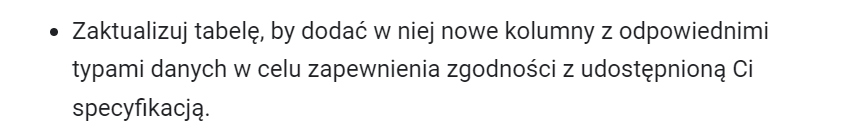

In [ ]:
%%bigquery

New Column Name          SQL Data Type
population               INTEGER
country_area             FLOAT
mobility                 RECORD
mobility.avg_retail      FLOAT
mobility.avg_grocery     FLOAT
mobility.avg_parks       FLOAT
mobility.avg_transit     FLOAT
mobility.avg_workplace   FLOAT
mobility.avg_residential FLOAT

In [ ]:
%%bigquery

ALTER TABLE `qwiklabs-gcp-00-aa50f3cd3f92.covid_359.oxford_policy_tracker_834`
ADD COLUMN population INTEGER,
ADD COLUMN country_area FLOAT64,
ADD COLUMN mobility STRUCT<
  avg_retail FLOAT64,
  avg_grocery FLOAT64,
  avg_parks FLOAT64,
  avg_transit FLOAT64,
  avg_workplace FLOAT64,
  avg_residential FLOAT64
>

##Zadanie 3. Dodaj dane dotyczące populacji poszczególnych krajów w kolumnie population

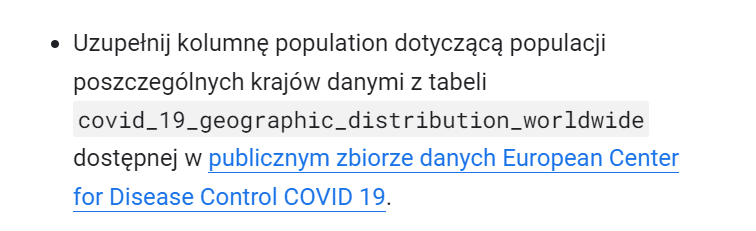

In [ ]:
# https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=covid19_ecdc&page=dataset&project=example-adae4&ws=!1m4!1m3!3m2!1sbigquery-public-data!2scovid19_ecdc

In [ ]:
%%bigquery

UPDATE covid_359.oxford_policy_tracker_834
SET population = t2.pop_data_2019
FROM (
    SELECT DISTINCT country_territory_code, pop_data_2019
    FROM `bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide`
    WHERE country_territory_code IS NOT NULL
) AS t2
WHERE alpha_3_code = t2.country_territory_code;

##Zadanie 4. Dodaj dane dotyczące obszaru geograficznego poszczególnych krajów w kolumnie country_area

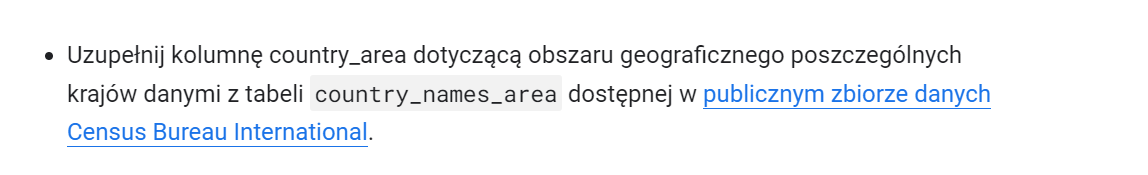

In [ ]:
# https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=census_bureau_international&page=dataset&project=example-adae4&ws=!1m4!1m3!3m2!1sbigquery-public-data!2scensus_bureau_international

In [ ]:
%%bigquery

UPDATE covid.oxford as t1
SET t1.country_area = t2.country_area
FROM (
    SELECT DISTINCT country_name, country_area
    FROM `bigquery-public-data.census_bureau_international.country_names_area`
    WHERE country_name IS NOT NULL
) AS t2
WHERE t1.country_name = t2.country_name;

In [ ]:
%%bigquery

UPDATE covid_359.oxford_policy_tracker_834 as t1
SET t1.country_area = t2.country_area
FROM (
    SELECT DISTINCT country_name, country_area
    FROM `bigquery-public-data.census_bureau_international.country_names_area`
    WHERE country_name IS NOT NULL
) AS t2
WHERE t1.country_name = t2.country_name;

##Zadanie 5. Wypełnij dane rekordu mobilności

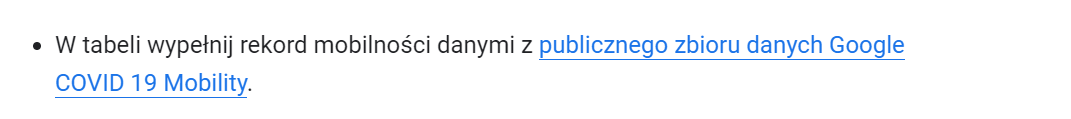

In [ ]:
# https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=covid19_govt_response&page=dataset&project=example-adae4

In [ ]:
%%bigquery

UPDATE covid_359.oxford_policy_tracker_834 as t1
SET t1.mobility.avg_retail = t2.avg_retail,
t1.mobility.avg_grocery = t2.avg_grocery,
t1.mobility.avg_parks = t2.avg_parks,
t1.mobility.avg_transit = t2.avg_transit,
t1.mobility.avg_workplace = t2.avg_workplace,
t1.mobility.avg_residential = t2.avg_residential

FROM (
 SELECT country_region, date,
      AVG(retail_and_recreation_percent_change_from_baseline) as avg_retail,
      AVG(grocery_and_pharmacy_percent_change_from_baseline)  as avg_grocery,
      AVG(parks_percent_change_from_baseline) as avg_parks,
      AVG(transit_stations_percent_change_from_baseline) as avg_transit,
      AVG( workplaces_percent_change_from_baseline ) as avg_workplace,
      AVG( residential_percent_change_from_baseline)  as avg_residential
      FROM `bigquery-public-data.covid19_google_mobility.mobility_report`
      GROUP BY country_region, date
) AS t2
WHERE t1.country_name = t2.country_region and t1.date = t2.date;

##Zadanie 6. Wyślij zapytanie o brakujące dane w kolumnach population i country_area

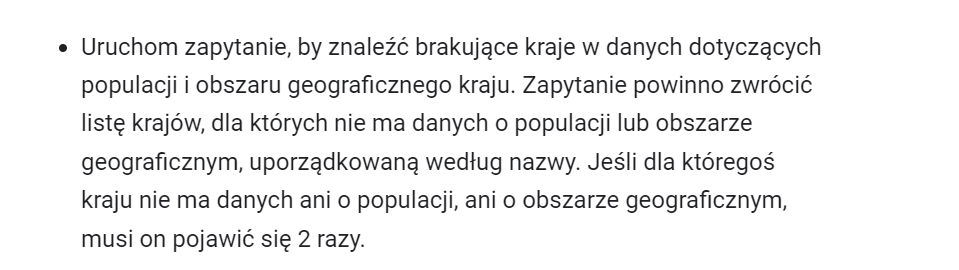

In [ ]:
%%bigquery

SELECT distinct country_name

FROM `qwiklabs-gcp-00-aa50f3cd3f92.covid_359.oxford_policy_tracker_834`

where population is null

union all

SELECT distinct country_name

FROM `qwiklabs-gcp-00-aa50f3cd3f92.covid_359.oxford_policy_tracker_834`

where country_area is null


order by 1